# Анализ результатов A/B теста


## Содержание
- [Введение](#intro)
- [Анализ датасета, сравнение конверсий в группах А и B](#probability)
- [A/B тест](#ab_test)
- [Выводы](#conclusion)


<a id='intro'></a>
### Введение

Для сравнения эффективности старой и новой версии веб-страницы был проведен A/B-тест с применением бутстрэппинга при проверке гипотез. Цель тестирования — определить, стоит ли интернет-магазину перейти на новую страницу, сохранить старую или продлить эксперимент для сбора дополнительных данных и принятия более обоснованного решения.

<a id='probability'></a>
## Анализ датасета, сравнение конверсий в группах А и B

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

Чтение датасета

In [ ]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Исследуем наш датасет

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [ ]:
print('Число уникальных пользователей:', len(df['user_id'].unique()))

Число уникальных пользователей: 290584


In [ ]:
print(f'Конверсия пользователей: {(len(df[df["converted"] == 1]) / df.shape[0]) * 100:.2f}%')

Конверсия пользователей: 11.97%


В корректном A/B-тесте должно быть:

`treatment` → `new_page` (новая страница)

`control` → `old_page` (старая страница)

Однако в датасете могут быть несоответствия и нужно проверить, есть ли они и сколько их.

In [ ]:
print((df.query('group == "treatment" & landing_page == "old_page"')['user_id'].count()) + (df.query('group == "control" & landing_page == "new_page"')['user_id'].count()))

3893


На следующем этапе мы очистим данные, удалив строки с некорректным соответствием групп и страниц:

Пользователи из treatment-группы, попавшие на old_page

Пользователи из control-группы, попавшие на new_page

Причина: мы не можем гарантировать, какая версия страницы была показана в этих случаях.

Создадим новый датафрейм df2, содержащий только строки, где значения в столбцах landing_page и group согласованы.

In [ ]:
df2 = df[
    ((df['group'] == 'treatment') & (df['landing_page'] == 'new_page')) |
    ((df['group'] == 'control') & (df['landing_page'] == 'old_page'))
].copy()

In [ ]:
assert((df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]) + (df2[((df2['group'] == 'control') == (df2['landing_page'] == 'old_page')) == False].shape[0]) == 0)

In [ ]:
print('Число уникальных пользователей:', len(df['user_id'].unique()))

Число уникальных пользователей: 290584


In [ ]:
# Добавляем булеву колонку для идентификации дубликатов user_id
df2['is_duplicated'] = df2.duplicated(subset='user_id', keep=False)  # keep=False помечает все дубли как True

# Получаем список всех user_id, которые имеют дубликаты
duplicated_user_ids = df2.loc[df2['is_duplicated'], 'user_id'].unique()

In [ ]:
df2.query('is_duplicated')

,user_id,timestamp,group,landing_page,converted,is_duplicated
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0,True
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0,True


In [ ]:
df2.drop_duplicates(subset=['user_id'], keep='first', inplace=True)
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted,is_duplicated
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0,True


In [ ]:
# удаляем 'is_duplicated' колонку, она нам больше не нужна
df2.drop('is_duplicated', axis=1, inplace=True)

In [ ]:
df2.head(1)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0


In [ ]:
print(f'Конверсия пользователей: {(len(df2[df2["converted"] == 1]) / df2.shape[0]) * 100:.2f}%')

Конверсия пользователей: 11.96%


In [125]:
res_old = (df2.query('group == "control"')['converted']).mean()

In [126]:
print(f'Конверсия пользователей, получивших контрольную страницу: {res_old * 100:.2f}%')

Конверсия пользователей, получивших контрольную страницу: 12.04%


In [127]:
res_new = (df2.query('group == "treatment"')['converted']).mean()

In [128]:
print(f'Конверсия пользователей, получивших экспериментальную страницу: {res_new * 100:.2f}%')

Конверсия пользователей, получивших экспериментальную страницу: 11.88%


In [ ]:
new_prob = df2.query('landing_page == "new_page"')['landing_page'].count() / df2.shape[0]

In [ ]:
print(f'Вероятность получить новую страницу: {new_prob * 100:.3f}')

Вероятность получить новую страницу: 50.006


### Итог

- **Вероятность конверсии для пользователей из экспериментальной группы (treatment): 0.118807**
- **Вероятность конверсии для пользователей из контрольной группы (control): 0.120386**

#### Согласно полученным результатам:
- Старая страница показала **чуть лучший** результат, но разница крайне незначительна
- Из-за почти одинаковой эффективности обеих версий мы **не можем утверждать**, что одна страница достоверно приводит к большему числу конверсий

#### Вывод:
Нет статистических доказательств, что какая-либо страница (новая или старая) обеспечивает более высокую конверсию, так как вероятности конверсии в обеих группах практически равны.

<a id='ab_test'></a>
## A/B тест

Нулевая и первая гипотезы следующие:


$$H_0: p_{new} = p_{old}$$

$$H_1: p_{new} > p_{old}$$


In [129]:
conv_new = (df2.query('group == "treatment"')['converted']).sum()
print('conv_new =', conv_new)

conv_new = 17264


In [130]:
conv_old = (df2.query('group == "control"')['converted']).sum()
print('conv_old =', conv_old)

conv_old = 17489


In [131]:
n_new = len(df2.query('landing_page == "new_page"'))
print('n_new =', n_new)

n_new = 145310


In [132]:
n_old = len(df2.query('landing_page == "old_page"'))
print('n_old =', n_old)

n_old = 145274



#### Формулы Z-теста для разности пропорций

1. Объединённая (pooled) пропорция под $H_0$:

   $$
   \hat p
   \;=\;
   \frac{\text{conv_new} \;+\; \text{conv_old}}{\,n_\text{new} \;+\; n_\text{old}\,}
   $$

2. Стандартная ошибка (SE) для разности пропорций при $H_0$:

   $$
   SE
   \;=\;
   \sqrt{\,
     \hat p\,(1 - \hat p)\,\Bigl(\frac{1}{n_\text{new}} + \frac{1}{n_\text{old}}\Bigr)
   \;}
   $$

3. Z-статистика:

   $$
   Z
   \;=\;
   \frac{
     \bigl(\,\frac{\text{conv_new}}{\,n_\text{new}\,}\bigr)
     \;-\;
     \bigl(\,\frac{\text{conv_old}}{\,n_\text{old}\,}\bigr)
   }{\,SE\,}
   $$

4. p-value при односторонней альтернативе $H_1: p_\text{new} > p_\text{old}$:

   $$
   p\_value
   \;=\;
   1 \;-\; \Phi\bigl(Z\bigr),
   $$

   где $\Phi(\cdot)$ — функция стандартного нормального распределения.

In [ ]:
import statsmodels.api as sm

count = np.array([conv_new, conv_old])
nobs  = np.array([n_new, n_old])

# Односторонний z-тест (H1: p_new > p_old)
z_stat, pval_one_sided = sm.stats.proportions_ztest(count, nobs, alternative = 'larger')

print(f"Z-статистика = {z_stat:.3f}")
print(f"Односторонний p-value = {pval_one_sided:.4f}")

Z-статистика = -1.311
Односторонний p-value = 0.9051


In [ ]:
import numpy as np
from scipy.stats import norm

p_new = conv_new / n_new
p_old = conv_old / n_old
delta_hat = p_new - p_old

# pooled-пропорция и стандартная ошибка для разности:
p_pooled = (conv_new + conv_old) / (n_new + n_old)
se = np.sqrt(p_pooled * (1 - p_pooled) * (1/n_new + 1/n_old))

# уровень доверия и соответствующий z-квантиль:
alpha = 0.05
z_quantile = abs(norm.ppf(alpha/2))

# доверительный интервал для разности пропорций:
ci_lower = delta_hat - z_quantile * se
ci_upper = delta_hat + z_quantile * se

print(f"p_new = {p_new:.6f}, p_old = {p_old:.6f}")
print(f"Наблюдаемая разность (delta_hat) = {delta_hat:.6f}")
print(f"Стандартная ошибка (SE) = {se:.6f}")
print(f"95% доверительный интервал для (p_new - p_old):")
print(f"[{ci_lower:.6f}, {ci_upper:.6f}]")

p_new = 0.118808, p_old = 0.120386
Наблюдаемая разность (delta_hat) = -0.001578
Стандартная ошибка (SE) = 0.001204
95% доверительный интервал для (p_new - p_old):
[-0.003938, 0.000781]


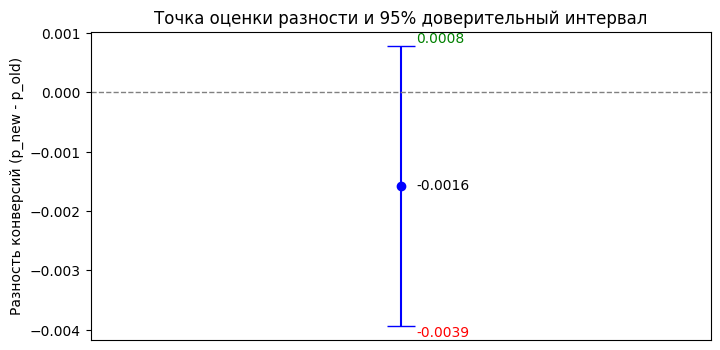

In [ ]:
plt.figure(figsize=(8, 4))
plt.errorbar(0, delta_hat, yerr=z_quantile * se, fmt='o', color='blue', capsize=10)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlim(-1, 1)
plt.xticks([])
plt.ylabel('Разность конверсий (p_new - p_old)')
plt.title('Точка оценки разности и 95% доверительный интервал')

plt.text(0.05, delta_hat, f'{delta_hat:.4f}', va='center', ha='left')
plt.text(0.05, ci_upper, f'{ci_upper:.4f}', va='bottom', ha='left', color='green')
plt.text(0.05, ci_lower, f'{ci_lower:.4f}', va='top', ha='left', color='red')

plt.show()

Мы не отвергаем нулевую гипотезу, так как p_value > alpha (alpha = 0.05)

Нет доказательств, что новая лучше старой.

In [ ]:
import numpy as np
from statsmodels.stats.power import GofChisquarePower, NormalIndPower

alpha = 0.05         # уровень значимости
power_desired = 0.8  # желаемая мощность (80%)
p0 = (conv_new + conv_old) / (n_new + n_old)  # приближённая baseline prop.
n1 = n_new
n2 = n_old

analysis = NormalIndPower()
ratio = n2 / n1
effect_size = analysis.solve_power(
    effect_size=None,
    nobs1=n1,
    alpha=alpha,
    power=power_desired,
    ratio=ratio,
    alternative='two-sided'
)

from math import sin, asin

h = effect_size
p_old = p0
asin_old = asin(np.sqrt(p_old))
p_new_approx = np.sin((h/2) + asin_old) ** 2
mde_approx = p_new_approx - p_old

print(f"Baseline пропорция (p0) = {p0:.4f}")
print(f"Минимально обнаруживаемый эффект (MDE) ≈ {mde_approx:.4%}")
print(f"Cohen's h = {h:.4f}")

Baseline пропорция (p0) = 0.1196
Минимально обнаруживаемый эффект (MDE) ≈ 0.3393%
Cohen's h = 0.0104


Интерпретация:

Baseline 11.96%: средняя конверсия в обеих группах (точка опоры).

MDE ≈ 0.34%: лишь такие или более значимые изменения (рост или падение конверсии минимум на 0.34 процентных пункта) тест с мощностью 80% гарантированно обнаружит. Любые эффекты слабее 0.34% будут скрыты статистическим шумом.

Cohen’s h = 0.0104: размер эффекта очень мал. Такое значение h говорит, что ожидаемые изменения между old и new настолько невелики, что считаются «микроэффектом» с точки зрения классических порогов (где обычно h≈0.20 уже считается «маленьким» эффектом)

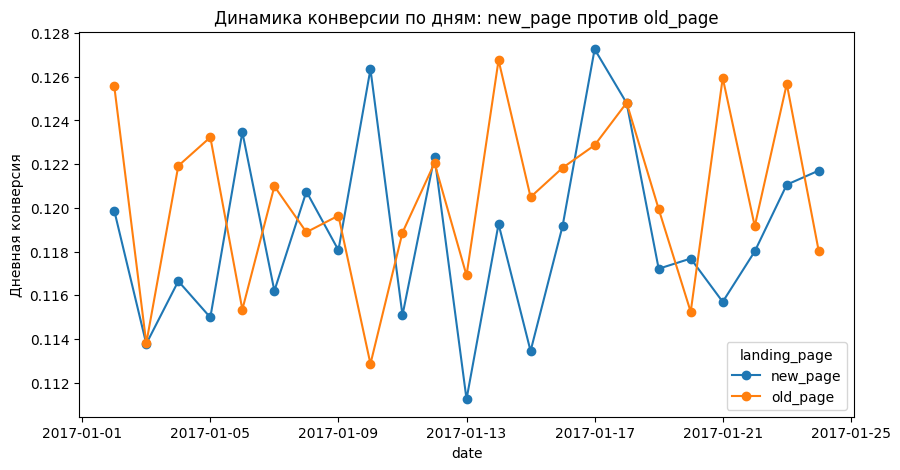

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df2['date'] = pd.to_datetime(df2['timestamp']).dt.date

daily = df2.groupby(['date', 'landing_page'])['converted']\
          .agg(['sum','count'])\
          .reset_index()

daily['rate'] = daily['sum'] / daily['count']

daily_pivot = daily.pivot(index='date', columns='landing_page', values='rate')

daily_pivot.plot(figsize=(10,5), marker='o')
plt.ylabel('Дневная конверсия')
plt.title('Динамика конверсии по дням: new_page против old_page')
plt.show()

Значимого эффекта в конверсии не замечено. Однако в реальности могут быть более глубинные различия, которые могут помочь принять решение. Например, время на странице, глубина просмотра. В датасете нет этих данных, однако если бы мы ими располагали, то могли бы более качественно провести A/B тестирование в плане нахождения эффекта.

## Выводы

1. Краткое резюме результатов  
   - В контрольной группе (контент A) конверсия составила 12.04 %.  
   - В тестовой группе (контент B) конверсия составила 11.88 %.  
   - Z-статистика равна -1.311, а p-значение равно 0.9051 (p ≥ 0.05).

2. Статистическая интерпретация  
   - Поскольку p ≥ 0.05, мы не можем отвергнуть нулевую гипотезу (H₀: конверсии в обеих группах равны).  
   - Это означает, что разница в конверсиях между контрольной и тестовой группами статистически незначима и может быть объяснена случайными колебаниями.

3. Практическая значимость  
   - Разница (11.88 % − 12.04 %) = -0.16 % слишком мала (или недостаточно доказана), чтобы с уверенностью утверждать о её реальной пользе.  
   - До дополнительного тестирования внедрять изменения, основанные на этих данных, нецелесообразно: эффект может не сохраниться на более широком трафике.

4. Ограничения и рекомендации по дальнейшим действиям  
   - Возможно, размер выборки недостаточен для обнаружения небольших, но всё же существующих изменений в конверсии.  
   - Стоит проверить отсутствие смещений при распределении пользователей (например, по времени или устройствам).  
   - Рекомендуется провести повторный эксперимент с большей выборкой или протестировать изменения на других сегментах аудитории (география, каналы трафика, устройства).

5. Рекомендации  
   - Магазину не переходить на новую веб-страницу, остаться на старой  
   - Снова запустить A/B-тест, собрав дополнительные данные